<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>06. Whole population Catboost classifier</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Binarización de variable delta_WHP](#24)<br>
    2.5. [Separación en train y test](#25)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Optimización de hiperparámetros](#32)<br>
    3.3. [Entrenamiento del modelo](#33)<br>
    3.4. [Mejores Hiperparámetros](#34)<br>
4. [Evaluación del modelo](#4)<br>
    4.1. [Cálculo de métricas](#41)<br>
    4.2. [Matriz de confusión](#42)<br>
    4.3. [ROC Curve](#43)<br>
    4.4. [Precision-Recall curve](#44)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier

import chardet

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
21755,Pozo 122-Pozo 93-2,Campo C,GAS,PAD-19,Pozo 122,2,Pozo 93,325.681374,321.544833,51.742415,242.838092,0,NO,198.4,0.0,Cerrado
8671,Pozo 30-Pozo 22-25,Campo B,OIL,PAD-6,Pozo 30,25,Pozo 22,1165.744783,1164.801290,46.891941,296.364013,2,NO,58.3,0.0,Abierto
22275,Pozo 379-Pozo 262-10,Campo F,OIL,PAD-78,Pozo 379,10,Pozo 262,291.866422,290.560233,27.581867,267.133811,0,NO,233.8,4.9,Cerrado
23517,Pozo 556-Pozo 271-32,Campo E,OIL,PAD-85,Pozo 556,32,Pozo 271,1341.540433,1341.505207,9.721905,203.184626,1,NO,306.8,0.0,Cerrado
19013,Pozo 408-Pozo 227-8,Campo F,OIL,PAD-60,Pozo 408,8,Pozo 227,1115.176059,1115.149521,-7.693431,191.775951,1,NO,64.0,0.0,Cerrado


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS        int64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="23"></a> <br>
### 2.3. Eliminación de valores nulos
**Dado que el modelo a desarrollar en el presente notebook será tomado como baseline, se eliminan los valores nulos para mayor practicidad**

In [ ]:
print("Cantidad de instancias totales =", df.shape[0])
# Eliminación de todos los valores nulos de dataset
df.dropna(inplace=True)
print("Cantidad de instancias sin valores nulos =", df.shape[0])

Cantidad de instancias totales = 26178
Cantidad de instancias sin valores nulos = 25929


<a id="24"></a> <br>
### 2.4. Binarización de variable delta_WHP

In [ ]:
# Se crea una nueva variable en donde se asigna valor 0 cuando delta_WHP = 0 y valor 1 cuando delta_WHP != 0
df["delta_WHP_binarized"] = df["delta_WHP"].apply(lambda val: 1 if val != 0 else 0)

<a id="25"></a> <br>
### 2.5. Separación en train y test

In [ ]:
# Selección de variable target
y = df.delta_WHP_binarized
# Selección de features
X = df.drop(["delta_WHP_binarized"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,  stratify= y, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19446
Instancias de test 
 6483


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
catboost_class = CatBoostClassifier(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO", "delta_WHP"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("catboost_class", catboost_class)])

<a id="32"></a> <br>
### 3.2. Optimización de hiperparámetros

In [ ]:
# Optimización de hiperparámetros del modelo con grid search y cross validation

kfolds=StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

params_grid = { 
                 "catboost_class__learning_rate" : [0.001, 0.01, 0.1],
                 "catboost_class__n_estimators" : [10, 100, 250],
                 "catboost_class__max_depth" : [5, 50, 80]
               }

model = GridSearchCV (pipe, params_grid,cv=kfolds, n_jobs = -1, scoring = "recall", refit = True)

<a id="33"></a> <br>
### 3.3. Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo
model.fit(X_train,y_train)

0:	learn: 0.6262666	total: 30.9ms	remaining: 7.7s
1:	learn: 0.5686074	total: 60.6ms	remaining: 7.52s
2:	learn: 0.5177960	total: 88.2ms	remaining: 7.26s
3:	learn: 0.4749445	total: 116ms	remaining: 7.12s
4:	learn: 0.4360378	total: 144ms	remaining: 7.06s
5:	learn: 0.4050380	total: 172ms	remaining: 6.98s
6:	learn: 0.3760802	total: 201ms	remaining: 6.97s
7:	learn: 0.3508827	total: 236ms	remaining: 7.14s
8:	learn: 0.3317214	total: 265ms	remaining: 7.1s
9:	learn: 0.3131666	total: 294ms	remaining: 7.05s
10:	learn: 0.2967396	total: 323ms	remaining: 7.01s
11:	learn: 0.2839934	total: 351ms	remaining: 6.97s
12:	learn: 0.2723078	total: 380ms	remaining: 6.94s
13:	learn: 0.2627396	total: 409ms	remaining: 6.89s
14:	learn: 0.2538893	total: 438ms	remaining: 6.86s
15:	learn: 0.2470103	total: 469ms	remaining: 6.85s
16:	learn: 0.2405687	total: 497ms	remaining: 6.8s
17:	learn: 0.2351510	total: 528ms	remaining: 6.8s
18:	learn: 0.2299654	total: 555ms	remaining: 6.75s
19:	learn: 0.2251611	total: 584ms	remainin

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ColumnDropper',
                                        ColumnDropper(columns=['ID_EVENTO',
                                                               'delta_WHP'])),
                                       ('column_transformer',
                                        ColumnTransformer(transformers=[('standard_scaler',
                                                                         StandardScaler(),
                                                                         ['D3D',
                                                                          'D2D',
                                                                          'DZ',
                                                                          'AZ',
                                                                          'WHP_i',
                                                              

<a id="34"></a> <br>
### 3.4. Mejores hiperparámetros

In [ ]:
# Mejores hiperparámetros obtenidos por cross validation y grid search

model.best_params_

{'catboost_class__learning_rate': 0.05,
 'catboost_class__max_depth': 10,
 'catboost_class__n_estimators': 250}

***
<a id="#4"></a> <br>
## 4. Evaluación del modelo

<a id="41"></a> <br>
### 4.1. Cálculo de métricas

In [ ]:
precision_train = precision_score(y_train, model.predict(X_train))
print("Precision train = ", precision_train)
precision_test = precision_score(y_test, model.predict(X_test))
print("Precision test = ", precision_test)

Precision train =  0.8966942148760331
Precision test =  0.8532110091743119


<a id="42"></a> <br>
### 4.2. Matriz de confusión

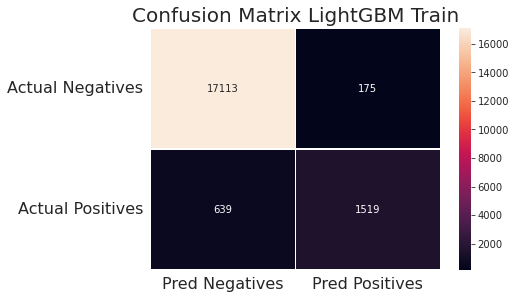

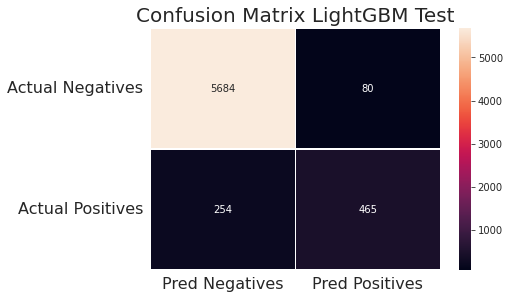

In [ ]:
# Matriz de confusión para modelo
conf_matrix = confusion_matrix(y_train,  model.predict(X_train))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Train", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

conf_matrix = confusion_matrix(y_test,  model.predict(X_test))
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix LightGBM Test", fontsize=20)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=16, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=16, rotation=360)
plt.show()

<a id="43"></a> <br>
### 4.3. ROC Curve

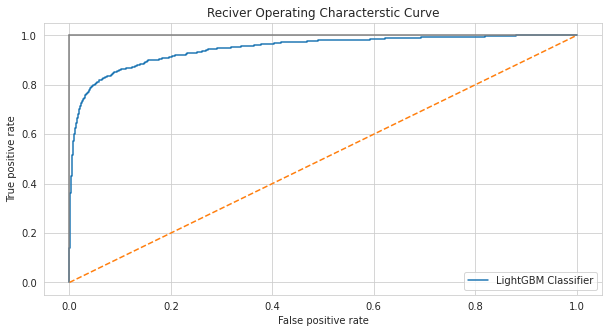

In [ ]:
# Obtencion de predicciones para graficar curva ROC
probsdmodel = model.predict_proba(X_test)
predsdmodel = probsdmodel[:,1]

lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,predsdmodel)


# Grafico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='LightGBM Classifier')

plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="44"></a> <br>
### 4.4. Precision-Recall Curve

0.8165683785692014


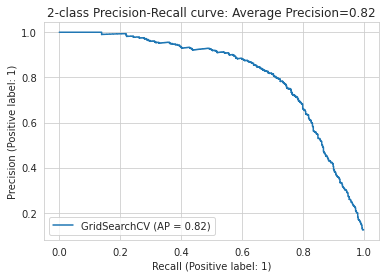

In [ ]:
# Curva Precision-Recall
average_precision = average_precision_score(y_test, predsdmodel)

print(average_precision)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision));